## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import torch.optim as optim


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,# 64
                                           shuffle=True,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=0)

In [ ]:
len(fmnist_dataset_test)

10000

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.Dropout(p = 0.1),            
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p = 0.1),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p = 0.1),            
            nn.LeakyReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
from torchsummary import summary
summary(TinyNeuralNetwork().to(device), (28*28,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 256]         200,960
           Dropout-3                 [128, 256]               0
         LeakyReLU-4                 [128, 256]               0
            Linear-5                 [128, 128]          32,896
           Dropout-6                 [128, 128]               0
         LeakyReLU-7                 [128, 128]               0
            Linear-8                 [128, 128]          16,512
       BatchNorm1d-9                 [128, 128]             256
          Dropout-10                 [128, 128]               0
        LeakyReLU-11                 [128, 128]               0
           Linear-12                  [128, 10]           1,290
Total params: 251,914
Trainable params: 251,914
Non-trainable params: 0
-------------------------------

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-3)
loss_func = nn.CrossEntropyLoss()

In [ ]:
loaders = {
    "train": train_loader, 
    "valid": test_loader
}

In [ ]:
from tqdm import tqdm_notebook
from torch.optim import lr_scheduler


scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

max_epochs = 15

accuracy = {"train": [], "valid": []}
loss_train_val = {"train": [], "valid": []}
model = model.to(device)
for epoch in tqdm_notebook(range(max_epochs)):
    scheduler.step()
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        loss_all = 0
        num_batch = 0
        for x_batch, y_batch in dataloader:
            num_batch += 1
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model.forward(x_batch.to(device))              
                 
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model.forward(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            loss = loss_func(outp, y_batch.to(device))
            loss_all += loss

            if k == "train":
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
        loss_train_val[k].append(loss_all/num_batch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1
Loader: train. Accuracy: 0.8102833333333334
Loader: valid. Accuracy: 0.8359
Epoch: 2
Loader: train. Accuracy: 0.8534333333333334
Loader: valid. Accuracy: 0.8472
Epoch: 3
Loader: train. Accuracy: 0.8658166666666667
Loader: valid. Accuracy: 0.8553
Epoch: 4
Loader: train. Accuracy: 0.8719833333333333
Loader: valid. Accuracy: 0.8675
Epoch: 5
Loader: train. Accuracy: 0.87765
Loader: valid. Accuracy: 0.8698
Epoch: 6
Loader: train. Accuracy: 0.8806333333333334
Loader: valid. Accuracy: 0.8651
Epoch: 7
Loader: train. Accuracy: 0.8988833333333334
Loader: valid. Accuracy: 0.8844
Epoch: 8
Loader: train. Accuracy: 0.9026
Loader: valid. Accuracy: 0.8853
Epoch: 9
Loader: train. Accuracy: 0.90465
Loader: valid. Accuracy: 0.8867
Epoch: 10
Loader: train. Accuracy: 0.9071833333333333
Loader: valid. Accuracy: 0.8897
Epoch: 11
Loader: train. Accuracy: 0.9085
Loader: valid. Accuracy: 0.8879
Epoch: 12
Loader: train. Accuracy: 0.9092666666666667
Loader: valid. Accuracy: 0.8893
Epoch: 13
Loader: train

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),          
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),           
            nn.LeakyReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
from torchsummary import summary

model = OverfittingNeuralNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-3)
loss_func = nn.CrossEntropyLoss()

summary(model, (28*28,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 256]         200,960
         LeakyReLU-3                 [128, 256]               0
            Linear-4                 [128, 128]          32,896
         LeakyReLU-5                 [128, 128]               0
            Linear-6                 [128, 128]          16,512
         LeakyReLU-7                 [128, 128]               0
            Linear-8                  [128, 10]           1,290
Total params: 251,658
Trainable params: 251,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.78
Params size (MB): 0.96
Estimated Total Size (MB): 3.12
----------------------------------------------------------------


In [ ]:
from tqdm import tqdm_notebook
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

max_epochs = 15

accuracy = {"train": [], "valid": []}
loss_train_val = {"train": [], "valid": []}
model = model.to(device)
for epoch in tqdm_notebook(range(max_epochs)):
    scheduler.step()
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        loss_all = 0
        num_batch = 0
        for x_batch, y_batch in dataloader:
            num_batch += 1
            if k == "train": 
                 model.train()
                 optimizer.zero_grad()
                 outp = model.forward(x_batch.to(device))              
                 
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model.forward(x_batch.to(device))

            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

            loss = loss_func(outp, y_batch.to(device))
            loss_all += loss

            if k == "train":
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
        loss_train_val[k].append(loss_all/num_batch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1
Loader: train. Accuracy: 0.8047833333333333
Loader: valid. Accuracy: 0.8457
Epoch: 2
Loader: train. Accuracy: 0.8605333333333334
Loader: valid. Accuracy: 0.8623
Epoch: 3
Loader: train. Accuracy: 0.8713
Loader: valid. Accuracy: 0.8594
Epoch: 4
Loader: train. Accuracy: 0.87875
Loader: valid. Accuracy: 0.8706
Epoch: 5
Loader: train. Accuracy: 0.8841666666666667
Loader: valid. Accuracy: 0.8682
Epoch: 6
Loader: train. Accuracy: 0.8881666666666667
Loader: valid. Accuracy: 0.871
Epoch: 7
Loader: train. Accuracy: 0.90885
Loader: valid. Accuracy: 0.8858
Epoch: 8
Loader: train. Accuracy: 0.9114166666666667
Loader: valid. Accuracy: 0.8872
Epoch: 9
Loader: train. Accuracy: 0.9138166666666667
Loader: valid. Accuracy: 0.888
Epoch: 10
Loader: train. Accuracy: 0.9159333333333334
Loader: valid. Accuracy: 0.8891
Epoch: 11
Loader: train. Accuracy: 0.9182166666666667
Loader: valid. Accuracy: 0.8905
Epoch: 12
Loader: train. Accuracy: 0.91965
Loader: valid. Accuracy: 0.8878
Epoch: 13
Loader: train.

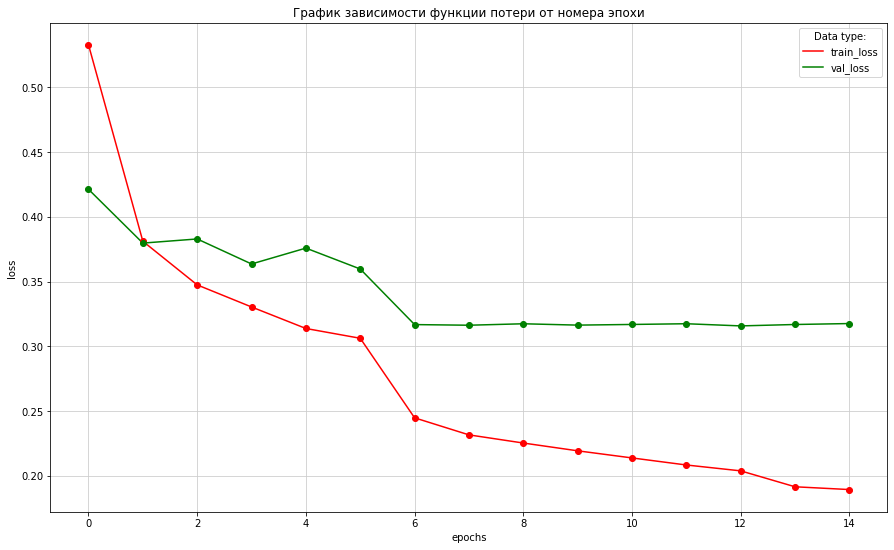

In [ ]:
# График функции потерь для модели в зависимости от числа эпох
plt.figure(figsize=(15, 9))
plt.plot(loss_train_val['train'], 'r-', label="train_loss")
plt.plot(loss_train_val['valid'], 'g-', label="val_loss")
plt.plot(loss_train_val['train'], 'ro')
plt.plot(loss_train_val['valid'], 'go')
plt.legend(loc='best', title='Data type:')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("График зависимости функции потери от номера эпохи")
plt.grid(color='0.8')
plt.show()

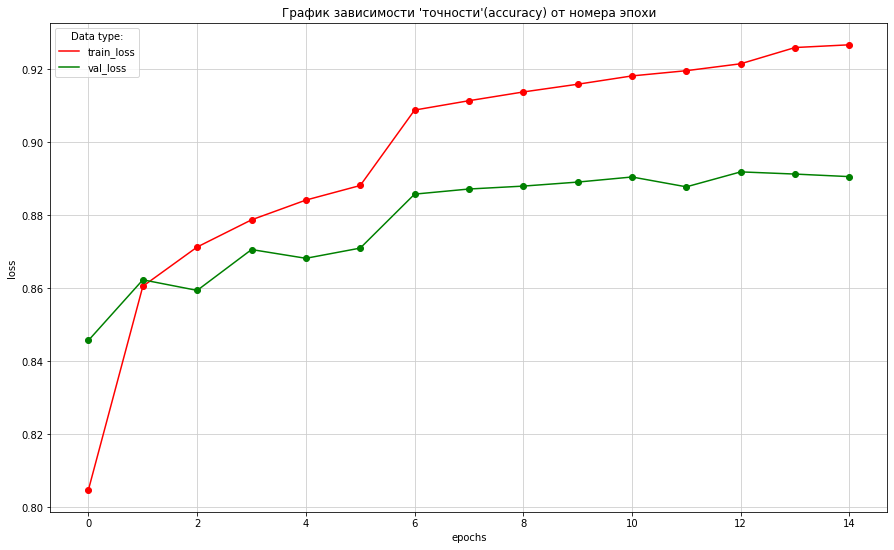

In [ ]:
# График точности для модели в зависимости от числа эпох
plt.figure(figsize=(15, 9))
plt.plot(accuracy['train'], 'r-', label="train_loss")
plt.plot(accuracy['valid'], 'g-', label="val_loss")
plt.plot(accuracy['train'], 'ro')
plt.plot(accuracy['valid'], 'go')
plt.legend(loc='best', title='Data type:')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("График зависимости 'точности'(accuracy) от номера эпохи")
plt.grid(color='0.8')
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(p = 0.4),            
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p = 0.4),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p = 0.4),            
            nn.LeakyReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
from torchsummary import summary

model = FixedNeuralNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-3)
loss_func = nn.CrossEntropyLoss()

summary(model, (28*28,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 256]         200,960
       BatchNorm1d-3                 [128, 256]             512
           Dropout-4                 [128, 256]               0
         LeakyReLU-5                 [128, 256]               0
            Linear-6                 [128, 128]          32,896
       BatchNorm1d-7                 [128, 128]             256
           Dropout-8                 [128, 128]               0
         LeakyReLU-9                 [128, 128]               0
           Linear-10                 [128, 128]          16,512
      BatchNorm1d-11                 [128, 128]             256
          Dropout-12                 [128, 128]               0
        LeakyReLU-13                 [128, 128]               0
           Linear-14                  [

In [ ]:
from tqdm import tqdm_notebook
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
max_epochs = 15

accuracy = {"train": [], "valid": []}
loss_train_val = {"train": [], "valid": []}
model = model.to(device)
for epoch in tqdm_notebook(range(max_epochs)):
    scheduler.step()
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        loss_all = 0
        num_batch = 0
        for x_batch, y_batch in dataloader:
            num_batch += 1
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model.forward(x_batch.to(device))              
                 
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model.forward(x_batch.to(device))

            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

            loss = loss_func(outp, y_batch.to(device))
            loss_all += loss

            if k == "train":
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
        loss_train_val[k].append(loss_all/num_batch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1
Loader: train. Accuracy: 0.7869333333333334
Loader: valid. Accuracy: 0.8397
Epoch: 2
Loader: train. Accuracy: 0.8374
Loader: valid. Accuracy: 0.8538
Epoch: 3
Loader: train. Accuracy: 0.8484333333333334
Loader: valid. Accuracy: 0.8629
Epoch: 4
Loader: train. Accuracy: 0.8580833333333333
Loader: valid. Accuracy: 0.8645
Epoch: 5
Loader: train. Accuracy: 0.8638666666666667
Loader: valid. Accuracy: 0.8719
Epoch: 6
Loader: train. Accuracy: 0.8680833333333333
Loader: valid. Accuracy: 0.8711
Epoch: 7
Loader: train. Accuracy: 0.88185
Loader: valid. Accuracy: 0.882
Epoch: 8
Loader: train. Accuracy: 0.8884
Loader: valid. Accuracy: 0.8846
Epoch: 9
Loader: train. Accuracy: 0.8907666666666667
Loader: valid. Accuracy: 0.8851
Epoch: 10
Loader: train. Accuracy: 0.8927333333333334
Loader: valid. Accuracy: 0.8868
Epoch: 11
Loader: train. Accuracy: 0.8938
Loader: valid. Accuracy: 0.8876
Epoch: 12
Loader: train. Accuracy: 0.8958166666666667
Loader: valid. Accuracy: 0.888
Epoch: 13
Loader: train. A

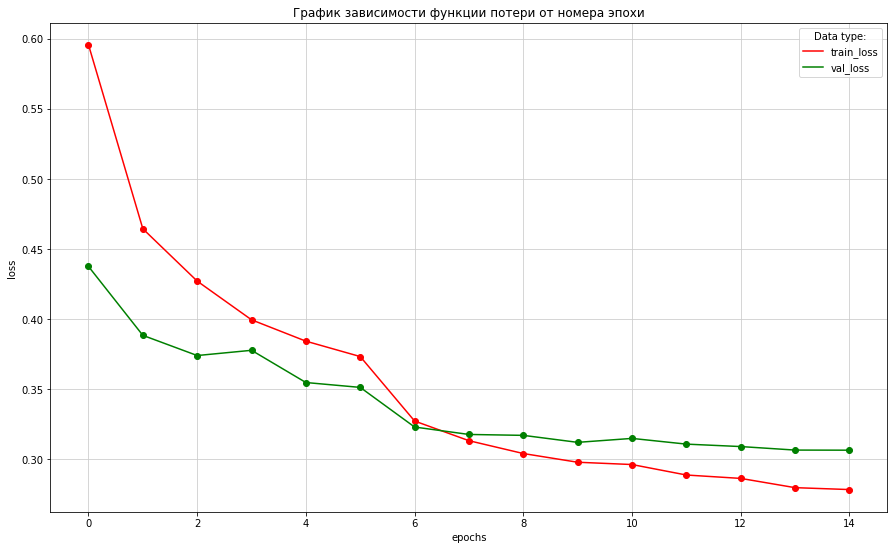

In [ ]:
# График функции потерь для модели в зависимости от числа эпох
plt.figure(figsize=(15, 9))
plt.plot(loss_train_val['train'], 'r-', label="train_loss")
plt.plot(loss_train_val['valid'], 'g-', label="val_loss")
plt.plot(loss_train_val['train'], 'ro')
plt.plot(loss_train_val['valid'], 'go')
plt.legend(loc='best', title='Data type:')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("График зависимости функции потери от номера эпохи")
plt.grid(color='0.8')
plt.show()

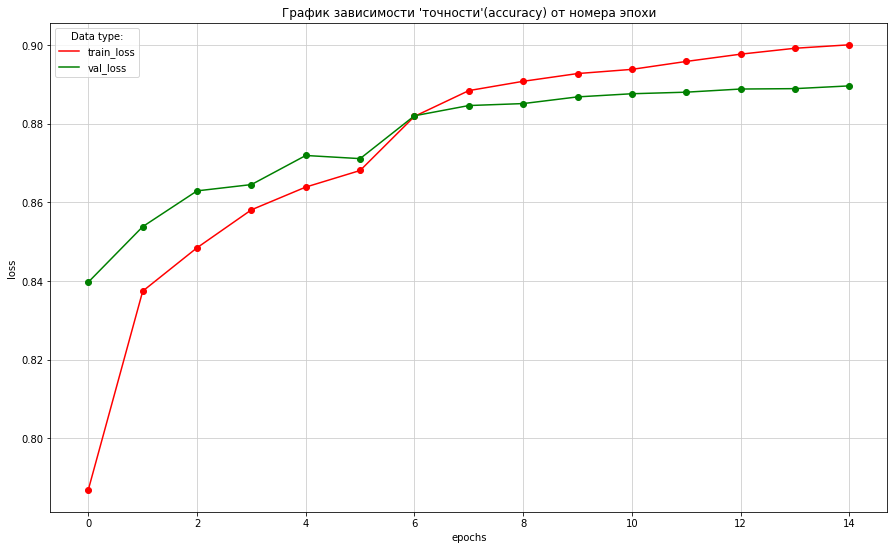

In [ ]:
# График точности для модели в зависимости от числа эпох
plt.figure(figsize=(15, 9))
plt.plot(accuracy['train'], 'r-', label="train_loss")
plt.plot(accuracy['valid'], 'g-', label="val_loss")
plt.plot(accuracy['train'], 'ro')
plt.plot(accuracy['valid'], 'go')
plt.legend(loc='best', title='Data type:')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("График зависимости 'точности'(accuracy) от номера эпохи")
plt.grid(color='0.8')
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

### Выводы:
1. Была реализована модель с 1 входным, 2 скрытыми и одним выходным полносвязанными слоями. Достигнутое качество равно 0.8916, что больше чем 0.885. Следовательно 1 пункт выполнен. 
2. Из предыдущей модели были убраны Dropout и BatchNorm1d. Из графика зависимости функции потерь от количества эпох видим, что начиная со 2 эпохи начинается переобучение, с 7 эпохи значение функции потерь выходит в плато, на val_loss. На обучающей выборке значении функции потерь продолжает уменьшаться. Данное поведение графиков явно сигнализирует о переобучении. Аналогичную ситуацию можно наблюдать на графике зависимости Accuracy от количества эпох.
3. Использована аналогичная архитектура нейронной сети что и в пункте 2 с добавлением Dropout и BatchNorm1d для борьбы с переобучением. Из графика зависимости функции потерь от количества эпох видим, что начиная только с 7 эпохи начинается переобучение, но в плато не выходит, на val_loss. Аналогичную ситуацию можно наблюдать на графике зависимости Accuracy от количества эпох. 